# Introduction

The essence of this project is to apply machine learning techniques to identify a perfume's brand using an image of its bottle. This is an evolution of my previous model, where I aimed to predict individual perfume preferences through likes and dislikes history. Since gathering throusands of data points on personal preference data is challenging, I shifted focus to a more achievable question: Is it possible for a machine learning model to differentiate between brands by analyzing the images of their perfume bottles?

Regarding the dataset, I developed web scrapers (Appendces A and B) for parfumo.com, extracting detailed information about perfumes on the Popular Brands section, including its name, brand, release year, fragrance notes, community rating, and bottle image.

# Implementation

## Description

The is a multi-class classification model that uses MobileNet V2 as the pretrained base, enhanced through fine-tuning techniques.

(1) Data Loading and Preprocessing

1.1. Removal of Unnecessary Features: The dataset initially includes various attributes. The 'Main Accords' column is dropped to streamline the feature set, focusing on directly relevant information.

1.2 Handling Missing Values: Entries lacking a 'Brand' are removed, ensuring that the dataset used for training is complete without gaps that could impair model training.

1.3 Standardization of Release Year: The 'Release Year' is processed to retain only entries with four-digit years, converting others to NaN, to maintain consistency in temporal data.

(2) Feature Visualization

2.1 Perfume Rating Distribution: A histogram plots the distribution of perfume ratings, providing insight into overall quality and user preferences.

2.2 Release Year Trends: A count plot for 'Release Year' highlights trends over time, possibly reflecting changes in perfume popularity or market dynamics.

2.3 Brand Distribution: Visualization of brand frequency with a count plot illustrates the dataset's diversity and the prevalence of different brands.

(3) Data Preparation for Model Training

3.1 Filtering Classes: Only brands with more than 10 instances are retained, ensuring the model learns from sufficiently represented classes.

3.2 Dataset Splitting: The dataset is divided into training, validation, and test sets, establishing a foundation for robust model training and evaluation.

3.3 Image Directory Structuring: Images are sorted into directories corresponding to their dataset split and brand, facilitating organized access during model training.

(4) Image Data Augmentation and Preparation

4.1 Training Image Augmentation: The training set undergoes augmentation (e.g., rotation, zoom, flipping) to enhance model generalization by simulating a broader range of visual input scenarios.

4.2 Image Resizing and Normalization: All images are resized to 160x160 pixels and normalized to ensure compatibility with the MobileNetV2 input requirements and improve model convergence.

(5) Model Construction and Training

5.1 Base Model Selection: MobileNetV2, pre-trained on the ImageNet dataset, is chosen for its efficiency and effectiveness in extracting features from images.

5.2 Custom Layer Addition: The model is customized by adding a global average pooling layer and a dense output layer with softmax activation, tailored to the number of perfume brands.

5.3 Model Compilation: Compiled with the Adam optimizer and categorical cross-entropy loss function, focusing initial training on the custom layers while the base model layers remain frozen.

(6) Evaluation and Fine-Tuning

6.1 Initial Evaluation: The model's accuracy is assessed on a separate test set post-initial training, providing a baseline performance metric.

6.2 Fine-Tuning Process:

6.2.1 Unfreezing Layers: A selective number of layers (starting from layer 100 onwards) in the base MobileNetV2 model are unfrozen to allow for nuanced adjustment based on the specific dataset.

6.2.2 Model Recompilation: The model is recompiled with a reduced learning rate (1/10th of the initial rate) for fine-tuning, ensuring subtle adjustments to the unfrozen layers.

6.2.3 Continued Training: The model undergoes additional epochs of training, integrating the fine-tuning adjustments to improve accuracy.

6.3 Fine-Tuned Model Evaluation: Performance metrics are recalculated post-fine-tuning to quantify improvements and ensure model robustness.

(7) Prediction and Visualization

7.1 Test Batch Prediction: A batch of images from the test set is processed through the model to generate predictions.

7.2 Visualization of Results: Predicted labels are visually compared to actual labels, alongside the perfume images, to demonstrate and evaluate the model's predictive capabilities.

## Data Import

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

/Users/hordiienkoalina/dev/fragrance-model/test-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Suppress FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Suppress UserWarnings
warnings.filterwarnings('ignore', category=UserWarning)

In [3]:
# Loading and preprocessing the dataset
data_path = '../data/popular_perfumes.csv'
df = pd.read_csv(data_path)

In [4]:
# Drop the 'Main Accords' column and remove rows with NaN in 'Brand'
df.drop('Main Accords', axis=1, inplace=True)
df.dropna(subset=['Brand'], inplace=True)

# Ensure 'Release Year' contains only 4-digit values or NaN
df['Release Year'] = df['Release Year'].apply(lambda x: np.nan if pd.isnull(x) or len(str(x)) != 4 else x)

## Data Exploration

1. Distribution of Perfume Ratings: The histogram showcasing perfume ratings reveals a normal distribution with a peak around higher scoress. This pattern, with ratings clustered towards the higher end, aligns with expectations considering the data was drawn from popular brands' perfumes.

2. Distribution of Release Years: A histogram detailing the release years of perfumes illustrates a growth trend in the number of releases over time, reaching its peak in recent years. This reflects the expected broadening selection of fragrances available over time.

3. Distribution of Brands: The bar chart displaying the number of perfumes by brand reveals variation in the range of fragrances each brand offers. Some brands present a wide assortment, while others have a more limited selection within the dataset. This spread is anticipated and mirrors the varied market presence and production scales among different perfume manufacturers.

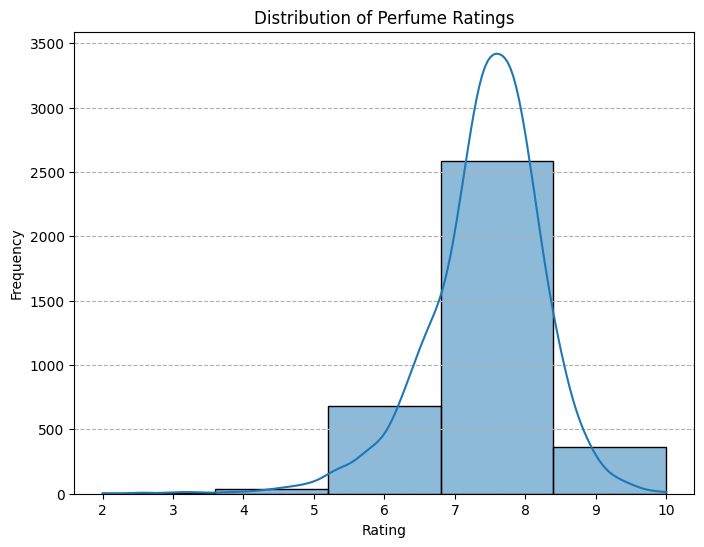

In [5]:
# Visualizing the distribution of perfume ratings
plt.figure(figsize=(8, 6))
sns.histplot(df['Rating'], bins=5, kde=True)
plt.title('Distribution of Perfume Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--')
plt.show()

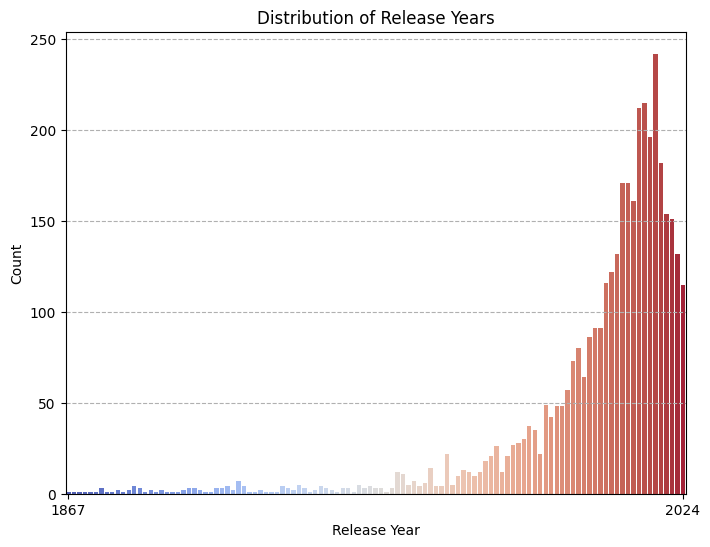

In [6]:
# Sort the DataFrame by 'Release Year' and visualize its distribution
df.sort_values('Release Year', inplace=True)
plt.figure(figsize=(8, 6))
sns.countplot(x='Release Year', data=df, palette="coolwarm")
plt.title('Distribution of Release Years')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--')
# Adjust x-ticks to only show the first and last year
locs, labels = plt.xticks()
plt.xticks([locs[0], locs[-1]], [labels[0].get_text(), labels[-1].get_text()])
plt.show()

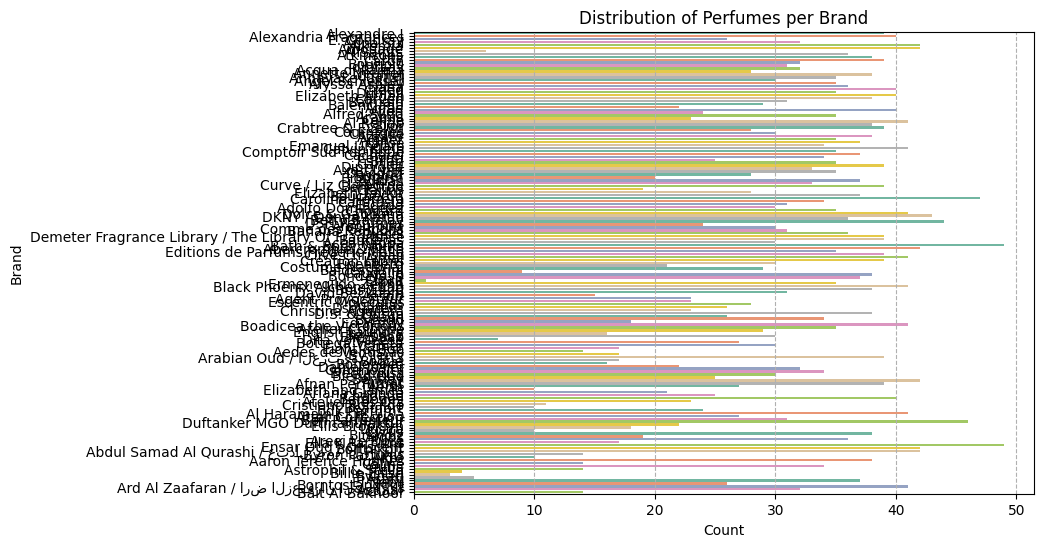

In [7]:
# Visualizing the distribution of brands
plt.figure(figsize=(8, 6))
sns.countplot(y='Brand', data=df, palette="Set2")
plt.title('Distribution of Perfumes per Brand')
plt.xlabel('Count')
plt.ylabel('Brand')
plt.grid(axis='x', linestyle='--')
plt.show()

## Data Pre-Processing

In [8]:
# Identify brands with more than 10 instances to ensure enough data for training/testing
class_counts = df['Brand'].value_counts()
valid_classes = class_counts[class_counts > 10].index

# Filter the dataset to include only those brands, ensuring a reliable split
df = df[df['Brand'].isin(valid_classes)]

In [9]:
# Split the data
df_train, df_test_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Brand'])
df_test, df_val = train_test_split(df_test_val, test_size=0.5, random_state=42, stratify=df_test_val['Brand'])

In [10]:
# Define a function to organize images into brand-specific folders for easier access
def create_and_copy_images(df, destination_folder):
    # Create the main destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    skipped_files = 0  # Counter for tracking unprocessable files
    for _, row in df.iterrows():  # Iterate through each row in the dataframe
        source_path, brand = row['Image Path'], row['Brand']  # Extract file path and brand
        # Skip the iteration if the source path is not a string (invalid path)
        if not isinstance(source_path, str):
            skipped_files += 1
            continue
        brand_dir = os.path.join(destination_folder, brand)  # Define brand-specific directory path
        # Create brand-specific directory if it doesn't exist
        if not os.path.exists(brand_dir):
            os.makedirs(brand_dir)
        # Define the destination path for the image
        destination_path = os.path.join(brand_dir, os.path.basename(source_path))
        # Skip copying if the source image doesn't exist
        if not os.path.exists(source_path):
            skipped_files += 1
            continue
        # Copy the image to its new location
        shutil.copy(source_path, destination_path)
    # Print the count of skipped files due to missing source paths
    if skipped_files > 0:
        print(f"Total skipped files: {skipped_files}")

In [11]:
# Preparing image directories for model training
train_images_dir, test_images_dir, validation_images_dir = 'train_images', 'test_images', 'validation_images'
create_and_copy_images(df_train, train_images_dir)
create_and_copy_images(df_test, test_images_dir)
create_and_copy_images(df_val, validation_images_dir)

Total skipped files: 1


In [12]:
# Setup for image data processing: specifying image size and batch size for model training
IMG_SIZE = 160  # Defines the uniform size for all images
BATCH_SIZE = 32  # Number of images to process in a batch

# Configure training data augmentation to enhance model generalization
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0,1]
    rotation_range=40,  # Random rotations
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Shearing transformations
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest')  # Strategy for filling in newly created pixels

# Data generator for validation data (no augmentation, just rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generator for test data (similarly, no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of augmented image data from the training directory
train_generator = train_datagen.flow_from_directory(
    train_images_dir,  # Source folder path
    target_size=(IMG_SIZE, IMG_SIZE),  # Resizes all images to 160x160
    batch_size=BATCH_SIZE,
    class_mode='categorical')  # For multi-class classification

# Generate batches of image data from the validation directory
validation_generator = validation_datagen.flow_from_directory(
    validation_images_dir,  # Source folder path
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')  # For multi-class classification

# Generate batches of image data from the test directory
test_generator = test_datagen.flow_from_directory(
    test_images_dir,  # Source folder path
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')  # For multi-class classification

Found 4643 images belonging to 148 classes.
Found 1768 images belonging to 148 classes.
Found 1783 images belonging to 148 classes.


## Pre-Trained Model

In [13]:
# Initialize the model architecture with MobileNetV2 as the foundational layer
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)  # Define the input image shape
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,  # Exclude the top layer to allow custom classifier
                                               weights='imagenet')  # Use pre-trained weights from ImageNet
base_model.trainable = False  # Prevent the base model from being trained to preserve learned features

In [14]:
# Enhance the base model with custom layers for specific task performance
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()  # Aggregate feature map to a single value per feature
prediction_layer = tf.keras.layers.Dense(len(train_generator.class_indices), activation='softmax')  # Prediction layer with softmax for class probabilities

inputs = tf.keras.Input(shape=IMG_SHAPE)  # Define input layer with the same shape as the base model
x = base_model(inputs, training=False)  # Pass inputs through the base model without training it
x = global_average_layer(x)  # Apply global average pooling to reduce feature dimensions
x = tf.keras.layers.Dropout(0.2)(x)  # Implement dropout for regularization, reducing overfitting
outputs = prediction_layer(x)  # Obtain final output predictions
model = tf.keras.Model(inputs, outputs)  # Construct the complete model with custom layers atop the base model

In [15]:
# Prepare the model for training by setting up the compiler
base_learning_rate = 0.0001  # Define a starting learning rate for optimization
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),  # Use Adam optimizer with a custom learning rate
              loss='categorical_crossentropy',  # Specify loss function for multi-class classification
              metrics=['accuracy'])  # Track accuracy as the performance metric

In [16]:
# Begin training the model with the specified parameters
initial_epochs = 150  # Set the number of epochs for the initial training phase
history = model.fit(train_generator,  # Use the training data generator
                    epochs=initial_epochs,  # Train for a predefined number of epochs
                    validation_data=validation_generator,  # Specify the validation data generator for evaluation
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,  # Calculate steps per epoch based on batch size
                    validation_steps=validation_generator.samples // BATCH_SIZE)  # Similarly, calculate validation steps

Epoch 1/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - accuracy: 0.0096 - loss: 5.4059 - val_accuracy: 0.0347 - val_loss: 4.7451
Epoch 2/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.0000e+00 - loss: 2.4579 - val_accuracy: 0.1250 - val_loss: 2.4181
Epoch 3/150


2024-03-25 18:35:34.475945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:35:34.532676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 38s 258ms/step - accuracy: 0.0375 - loss: 4.7885 - val_accuracy: 0.0994 - val_loss: 4.3879
Epoch 4/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - accuracy: 0.0312 - loss: 2.3451 - val_accuracy: 0.2500 - val_loss: 1.9827
Epoch 5/150


2024-03-25 18:36:13.168666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:36:13.236424: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 39s 261ms/step - accuracy: 0.0933 - loss: 4.4340 - val_accuracy: 0.1824 - val_loss: 4.0952
Epoch 6/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.2188 - loss: 2.0572 - val_accuracy: 0.6250 - val_loss: 1.7587
Epoch 7/150


2024-03-25 18:36:52.372797: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:36:52.439353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 40s 269ms/step - accuracy: 0.1644 - loss: 4.0951 - val_accuracy: 0.2534 - val_loss: 3.8401
Epoch 8/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - accuracy: 0.2500 - loss: 1.7260 - val_accuracy: 0.1250 - val_loss: 1.8707
Epoch 9/150


2024-03-25 18:37:32.680753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:37:32.754211: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 40s 265ms/step - accuracy: 0.2227 - loss: 3.8362 - val_accuracy: 0.3028 - val_loss: 3.6327
Epoch 10/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.1562 - loss: 1.8126 - val_accuracy: 0.3750 - val_loss: 1.6114
Epoch 11/150


2024-03-25 18:38:12.477331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:38:12.545985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.2664 - loss: 3.6420 - val_accuracy: 0.3335 - val_loss: 3.4542
Epoch 12/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.2188 - loss: 1.8827 - val_accuracy: 0.6250 - val_loss: 1.4960
Epoch 13/150


2024-03-25 18:38:53.558322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:38:53.655836: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 43s 290ms/step - accuracy: 0.3006 - loss: 3.4482 - val_accuracy: 0.3619 - val_loss: 3.2948
Epoch 14/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step - accuracy: 0.3438 - loss: 1.5760 - val_accuracy: 0.3750 - val_loss: 2.0471
Epoch 15/150


2024-03-25 18:39:36.970289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:39:37.034595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 281ms/step - accuracy: 0.3361 - loss: 3.2864 - val_accuracy: 0.3790 - val_loss: 3.1639
Epoch 16/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.2500 - loss: 1.7733 - val_accuracy: 0.3750 - val_loss: 1.5898
Epoch 17/150


2024-03-25 18:40:19.206365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:40:19.303379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 283ms/step - accuracy: 0.3552 - loss: 3.1518 - val_accuracy: 0.4011 - val_loss: 3.0433
Epoch 18/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.5000 - loss: 1.4523 - val_accuracy: 0.5000 - val_loss: 1.5170
Epoch 19/150


2024-03-25 18:41:01.774613: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:41:01.849558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 300ms/step - accuracy: 0.3748 - loss: 3.0428 - val_accuracy: 0.4239 - val_loss: 2.9364
Epoch 20/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.3750 - loss: 1.4942 - val_accuracy: 0.5000 - val_loss: 1.3259
Epoch 21/150


2024-03-25 18:41:46.592192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:41:46.678936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 48s 324ms/step - accuracy: 0.4073 - loss: 2.9266 - val_accuracy: 0.4381 - val_loss: 2.8388
Epoch 22/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.4062 - loss: 1.4032 - val_accuracy: 0.1250 - val_loss: 1.8742
Epoch 23/150


2024-03-25 18:42:34.867962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:42:34.945351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 302ms/step - accuracy: 0.4062 - loss: 2.8297 - val_accuracy: 0.4557 - val_loss: 2.7565
Epoch 24/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - accuracy: 0.4062 - loss: 1.4514 - val_accuracy: 0.3750 - val_loss: 1.3957
Epoch 25/150


2024-03-25 18:43:19.999019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:43:20.069536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 310ms/step - accuracy: 0.4327 - loss: 2.7348 - val_accuracy: 0.4653 - val_loss: 2.6852
Epoch 26/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.5000 - loss: 1.1598 - val_accuracy: 0.2500 - val_loss: 1.5461
Epoch 27/150


2024-03-25 18:44:06.174043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:44:06.256437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 48s 322ms/step - accuracy: 0.4284 - loss: 2.6991 - val_accuracy: 0.4830 - val_loss: 2.6128
Epoch 28/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.5000 - loss: 1.1456 - val_accuracy: 0.2500 - val_loss: 1.4431
Epoch 29/150


2024-03-25 18:44:54.587426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:44:54.663705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 311ms/step - accuracy: 0.4476 - loss: 2.6399 - val_accuracy: 0.4949 - val_loss: 2.5509
Epoch 30/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 769us/step - accuracy: 0.4375 - loss: 1.4272 - val_accuracy: 0.6250 - val_loss: 0.8781
Epoch 31/150


2024-03-25 18:45:41.011618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:45:41.107087: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 327ms/step - accuracy: 0.4832 - loss: 2.4710 - val_accuracy: 0.5040 - val_loss: 2.4911
Epoch 32/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.7812 - loss: 0.9115 - val_accuracy: 0.7500 - val_loss: 0.9227
Epoch 33/150


2024-03-25 18:46:29.999786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:46:30.093000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 51s 342ms/step - accuracy: 0.4771 - loss: 2.4869 - val_accuracy: 0.5188 - val_loss: 2.4322
Epoch 34/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.3438 - loss: 1.2672 - val_accuracy: 0.6250 - val_loss: 0.8334
Epoch 35/150


2024-03-25 18:47:21.103873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:47:21.183356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.4766 - loss: 2.4485 - val_accuracy: 0.5318 - val_loss: 2.3671
Epoch 36/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.5000 - loss: 1.2066 - val_accuracy: 0.1250 - val_loss: 1.6618
Epoch 37/150


2024-03-25 18:48:08.529549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:48:08.611888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 50s 334ms/step - accuracy: 0.5097 - loss: 2.3402 - val_accuracy: 0.5341 - val_loss: 2.3335
Epoch 38/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.5938 - loss: 1.0749 - val_accuracy: 0.6250 - val_loss: 0.8742
Epoch 39/150


2024-03-25 18:48:58.324073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:48:58.412803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 48s 325ms/step - accuracy: 0.5082 - loss: 2.3167 - val_accuracy: 0.5409 - val_loss: 2.2798
Epoch 40/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.6562 - loss: 0.9667 - val_accuracy: 0.6250 - val_loss: 1.2656
Epoch 41/150


2024-03-25 18:49:46.989520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:49:47.067072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 50s 340ms/step - accuracy: 0.5115 - loss: 2.2850 - val_accuracy: 0.5551 - val_loss: 2.2344
Epoch 42/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.3438 - loss: 1.5103 - val_accuracy: 0.2500 - val_loss: 1.5037
Epoch 43/150


2024-03-25 18:50:37.761661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:50:37.840874: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 50s 337ms/step - accuracy: 0.5280 - loss: 2.2073 - val_accuracy: 0.5642 - val_loss: 2.1920
Epoch 44/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.5938 - loss: 1.0295 - val_accuracy: 0.5000 - val_loss: 1.0487
Epoch 45/150


2024-03-25 18:51:28.232082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:51:28.324158: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 52s 352ms/step - accuracy: 0.5235 - loss: 2.1748 - val_accuracy: 0.5665 - val_loss: 2.1537
Epoch 46/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - accuracy: 0.5000 - loss: 1.2016 - val_accuracy: 0.3750 - val_loss: 1.0712
Epoch 47/150


2024-03-25 18:52:20.763002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:52:20.833480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 331ms/step - accuracy: 0.5417 - loss: 2.1499 - val_accuracy: 0.5733 - val_loss: 2.1222
Epoch 48/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.4688 - loss: 1.3436 - val_accuracy: 0.6250 - val_loss: 1.0024
Epoch 49/150


2024-03-25 18:53:10.263210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:53:10.342636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: 0.5532 - loss: 2.1285 - val_accuracy: 0.5750 - val_loss: 2.0877
Epoch 50/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.5312 - loss: 1.0720 - val_accuracy: 0.5000 - val_loss: 1.1087
Epoch 51/150


2024-03-25 18:53:54.937916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:53:55.015840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - accuracy: 0.5710 - loss: 2.0183 - val_accuracy: 0.5830 - val_loss: 2.0519
Epoch 52/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.5000 - loss: 0.9750 - val_accuracy: 0.5000 - val_loss: 1.2376
Epoch 53/150


2024-03-25 18:54:36.642475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:54:36.725794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.5747 - loss: 2.0129 - val_accuracy: 0.5852 - val_loss: 2.0164
Epoch 54/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.5312 - loss: 1.0446 - val_accuracy: 0.6250 - val_loss: 1.0444
Epoch 55/150


2024-03-25 18:55:20.033892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:55:20.130067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 302ms/step - accuracy: 0.5868 - loss: 1.9954 - val_accuracy: 0.6006 - val_loss: 1.9887
Epoch 56/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.6250 - loss: 0.8895 - val_accuracy: 0.7500 - val_loss: 0.7889
Epoch 57/150


2024-03-25 18:56:05.178582: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:56:05.277096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.5796 - loss: 1.9437 - val_accuracy: 0.5994 - val_loss: 1.9569
Epoch 58/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - accuracy: 0.5938 - loss: 0.9565 - val_accuracy: 0.7500 - val_loss: 0.7575
Epoch 59/150


2024-03-25 18:56:50.860365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:56:50.930967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 41s 279ms/step - accuracy: 0.5924 - loss: 1.8858 - val_accuracy: 0.6045 - val_loss: 1.9205
Epoch 60/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.7188 - loss: 0.7797 - val_accuracy: 0.2500 - val_loss: 1.6176
Epoch 61/150


2024-03-25 18:57:32.620891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:57:32.711482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 302ms/step - accuracy: 0.5910 - loss: 1.9186 - val_accuracy: 0.6102 - val_loss: 1.8963
Epoch 62/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.7188 - loss: 0.6287 - val_accuracy: 0.6250 - val_loss: 0.9440
Epoch 63/150


2024-03-25 18:58:17.838948: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:58:17.936718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 43s 291ms/step - accuracy: 0.6004 - loss: 1.8727 - val_accuracy: 0.6142 - val_loss: 1.8762
Epoch 64/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.7188 - loss: 0.8368 - val_accuracy: 1.0000 - val_loss: 0.5744
Epoch 65/150


2024-03-25 18:59:01.509159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:59:01.588658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 295ms/step - accuracy: 0.6039 - loss: 1.8514 - val_accuracy: 0.6250 - val_loss: 1.8398
Epoch 66/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.5000 - loss: 1.0463 - val_accuracy: 0.3750 - val_loss: 1.2114
Epoch 67/150


2024-03-25 18:59:45.756192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 18:59:45.834064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 293ms/step - accuracy: 0.6108 - loss: 1.7965 - val_accuracy: 0.6267 - val_loss: 1.8263
Epoch 68/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.7188 - loss: 0.7303 - val_accuracy: 0.6250 - val_loss: 0.9270
Epoch 69/150


2024-03-25 19:00:29.651723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:00:29.737737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.6012 - loss: 1.8140 - val_accuracy: 0.6284 - val_loss: 1.8023
Epoch 70/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.6875 - loss: 0.9075 - val_accuracy: 0.6250 - val_loss: 0.9095
Epoch 71/150


2024-03-25 19:01:12.927099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:01:13.000006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 309ms/step - accuracy: 0.6069 - loss: 1.8004 - val_accuracy: 0.6301 - val_loss: 1.7795
Epoch 72/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.5625 - loss: 0.9837 - val_accuracy: 0.8750 - val_loss: 0.4989
Epoch 73/150


2024-03-25 19:01:59.183661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:01:59.258579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 314ms/step - accuracy: 0.6228 - loss: 1.7355 - val_accuracy: 0.6432 - val_loss: 1.7542
Epoch 74/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.6250 - loss: 0.9407 - val_accuracy: 0.6250 - val_loss: 0.8336
Epoch 75/150


2024-03-25 19:02:46.386766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:02:46.461946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.6364 - loss: 1.6885 - val_accuracy: 0.6494 - val_loss: 1.7235
Epoch 76/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.6250 - loss: 0.8787 - val_accuracy: 0.2500 - val_loss: 1.5819
Epoch 77/150


2024-03-25 19:03:29.664524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:03:29.737292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: 0.6299 - loss: 1.7048 - val_accuracy: 0.6528 - val_loss: 1.7085
Epoch 78/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - accuracy: 0.4375 - loss: 1.1966 - val_accuracy: 0.5000 - val_loss: 1.0709
Epoch 79/150


2024-03-25 19:04:14.293568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:04:14.351084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 42s 280ms/step - accuracy: 0.6357 - loss: 1.6690 - val_accuracy: 0.6562 - val_loss: 1.6860
Epoch 80/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - accuracy: 0.7812 - loss: 0.6284 - val_accuracy: 0.5000 - val_loss: 1.1278
Epoch 81/150


2024-03-25 19:04:56.306109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:04:56.372617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 293ms/step - accuracy: 0.6403 - loss: 1.6385 - val_accuracy: 0.6551 - val_loss: 1.6726
Epoch 82/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.5625 - loss: 0.9870 - val_accuracy: 0.5000 - val_loss: 1.2092
Epoch 83/150


2024-03-25 19:05:40.167318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:05:40.242440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 306ms/step - accuracy: 0.6466 - loss: 1.6212 - val_accuracy: 0.6648 - val_loss: 1.6553
Epoch 84/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.5000 - loss: 1.0525 - val_accuracy: 0.6250 - val_loss: 0.6995
Epoch 85/150


2024-03-25 19:06:25.981900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:06:26.062513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 302ms/step - accuracy: 0.6429 - loss: 1.6136 - val_accuracy: 0.6705 - val_loss: 1.6337
Epoch 86/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.6562 - loss: 0.8493 - val_accuracy: 0.7500 - val_loss: 0.6845
Epoch 87/150


2024-03-25 19:07:11.130689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:07:11.210620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 43s 287ms/step - accuracy: 0.6492 - loss: 1.6314 - val_accuracy: 0.6716 - val_loss: 1.6141
Epoch 88/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.5938 - loss: 0.7873 - val_accuracy: 0.7500 - val_loss: 0.5998
Epoch 89/150


2024-03-25 19:07:53.896896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:07:53.969941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 303ms/step - accuracy: 0.6594 - loss: 1.5061 - val_accuracy: 0.6773 - val_loss: 1.5952
Epoch 90/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.6250 - loss: 0.8647 - val_accuracy: 0.8750 - val_loss: 0.7375
Epoch 91/150


2024-03-25 19:08:39.062138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:08:39.138091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 43s 292ms/step - accuracy: 0.6542 - loss: 1.5714 - val_accuracy: 0.6790 - val_loss: 1.5831
Epoch 92/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.6562 - loss: 0.7428 - val_accuracy: 0.7500 - val_loss: 0.5585
Epoch 93/150


2024-03-25 19:09:22.768738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:09:22.833216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.6749 - loss: 1.5474 - val_accuracy: 0.6812 - val_loss: 1.5676
Epoch 94/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.6875 - loss: 0.8332 - val_accuracy: 0.7500 - val_loss: 0.6738
Epoch 95/150


2024-03-25 19:10:06.011919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:10:06.083448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: 0.6763 - loss: 1.5070 - val_accuracy: 0.6847 - val_loss: 1.5490
Epoch 96/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.7188 - loss: 0.8441 - val_accuracy: 0.8750 - val_loss: 0.4985
Epoch 97/150


2024-03-25 19:10:50.733998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:10:50.801338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 44s 294ms/step - accuracy: 0.6749 - loss: 1.5213 - val_accuracy: 0.6886 - val_loss: 1.5288
Epoch 98/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - accuracy: 0.6250 - loss: 0.7552 - val_accuracy: 0.6250 - val_loss: 0.9219
Epoch 99/150


2024-03-25 19:11:34.936760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:11:35.013793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 301ms/step - accuracy: 0.6693 - loss: 1.5089 - val_accuracy: 0.6875 - val_loss: 1.5212
Epoch 100/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.6562 - loss: 0.7159 - val_accuracy: 0.7500 - val_loss: 0.6996
Epoch 101/150


2024-03-25 19:12:20.093776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:12:20.164493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.6707 - loss: 1.5065 - val_accuracy: 0.6983 - val_loss: 1.4938
Epoch 102/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.7188 - loss: 0.7054 - val_accuracy: 0.5000 - val_loss: 1.3643
Epoch 103/150


2024-03-25 19:13:05.593100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:13:05.665042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 306ms/step - accuracy: 0.6657 - loss: 1.4915 - val_accuracy: 0.7006 - val_loss: 1.4807
Epoch 104/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.7500 - loss: 0.5612 - val_accuracy: 0.8750 - val_loss: 0.7383
Epoch 105/150


2024-03-25 19:13:51.261842: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:13:51.355870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 306ms/step - accuracy: 0.6841 - loss: 1.4331 - val_accuracy: 0.6994 - val_loss: 1.4747
Epoch 106/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.6562 - loss: 0.7785 - val_accuracy: 0.5000 - val_loss: 0.8987
Epoch 107/150


2024-03-25 19:14:37.137501: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:14:37.217773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 306ms/step - accuracy: 0.6998 - loss: 1.4234 - val_accuracy: 0.7057 - val_loss: 1.4592
Epoch 108/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.5312 - loss: 0.9613 - val_accuracy: 0.6250 - val_loss: 0.7383
Epoch 109/150


2024-03-25 19:15:22.907070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:15:22.983447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 304ms/step - accuracy: 0.6985 - loss: 1.3809 - val_accuracy: 0.7040 - val_loss: 1.4523
Epoch 110/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - accuracy: 0.6250 - loss: 0.8050 - val_accuracy: 0.8750 - val_loss: 0.4411
Epoch 111/150


2024-03-25 19:16:08.413207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:16:08.483500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 316ms/step - accuracy: 0.6940 - loss: 1.3938 - val_accuracy: 0.7080 - val_loss: 1.4358
Epoch 112/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.8125 - loss: 0.5480 - val_accuracy: 0.6250 - val_loss: 0.7496
Epoch 113/150


2024-03-25 19:16:55.652435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:16:55.737492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 313ms/step - accuracy: 0.6974 - loss: 1.4093 - val_accuracy: 0.7108 - val_loss: 1.4239
Epoch 114/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.7188 - loss: 0.7505 - val_accuracy: 0.8750 - val_loss: 0.6485
Epoch 115/150


2024-03-25 19:17:42.432668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:17:42.528495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 301ms/step - accuracy: 0.6952 - loss: 1.3682 - val_accuracy: 0.7114 - val_loss: 1.4094
Epoch 116/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.6562 - loss: 0.7031 - val_accuracy: 0.5000 - val_loss: 1.1828
Epoch 117/150


2024-03-25 19:18:27.675479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:18:27.750415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 48s 324ms/step - accuracy: 0.7048 - loss: 1.3338 - val_accuracy: 0.7131 - val_loss: 1.4037
Epoch 118/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.7500 - loss: 0.7033 - val_accuracy: 1.0000 - val_loss: 0.2626
Epoch 119/150


2024-03-25 19:19:15.992969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:19:16.062730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 51s 345ms/step - accuracy: 0.6935 - loss: 1.3643 - val_accuracy: 0.7170 - val_loss: 1.3897
Epoch 120/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5938 - loss: 0.8979 - val_accuracy: 1.0000 - val_loss: 0.3153
Epoch 121/150


2024-03-25 19:20:07.395685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:20:07.481626: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.7007 - loss: 1.3616 - val_accuracy: 0.7205 - val_loss: 1.3705
Epoch 122/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.7812 - loss: 0.6097 - val_accuracy: 0.6250 - val_loss: 0.9438
Epoch 123/150


2024-03-25 19:20:53.101306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:20:53.173067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 318ms/step - accuracy: 0.7062 - loss: 1.3549 - val_accuracy: 0.7233 - val_loss: 1.3642
Epoch 124/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.7500 - loss: 0.7342 - val_accuracy: 0.7500 - val_loss: 0.8207
Epoch 125/150


2024-03-25 19:21:40.650714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:21:40.755420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 48s 321ms/step - accuracy: 0.7149 - loss: 1.3338 - val_accuracy: 0.7222 - val_loss: 1.3510
Epoch 126/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.8438 - loss: 0.4756 - val_accuracy: 0.6250 - val_loss: 0.8713
Epoch 127/150


2024-03-25 19:22:28.641269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:22:28.724012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 310ms/step - accuracy: 0.7115 - loss: 1.3199 - val_accuracy: 0.7227 - val_loss: 1.3373
Epoch 128/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.6562 - loss: 0.6968 - val_accuracy: 0.7500 - val_loss: 0.8439
Epoch 129/150


2024-03-25 19:23:15.052095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:23:15.125230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 305ms/step - accuracy: 0.7059 - loss: 1.3278 - val_accuracy: 0.7267 - val_loss: 1.3278
Epoch 130/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.6875 - loss: 0.9116 - val_accuracy: 0.7500 - val_loss: 0.5289
Epoch 131/150


2024-03-25 19:24:00.838024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:24:00.913415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step - accuracy: 0.7236 - loss: 1.3100 - val_accuracy: 0.7324 - val_loss: 1.3139
Epoch 132/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.7500 - loss: 0.5970 - val_accuracy: 0.7500 - val_loss: 0.6633
Epoch 133/150


2024-03-25 19:24:48.348094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:24:48.426289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.7196 - loss: 1.2656 - val_accuracy: 0.7335 - val_loss: 1.3048
Epoch 134/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.8125 - loss: 0.5132 - val_accuracy: 0.6250 - val_loss: 0.8520
Epoch 135/150


2024-03-25 19:25:35.422358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:25:35.496232: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 46s 309ms/step - accuracy: 0.7139 - loss: 1.2724 - val_accuracy: 0.7335 - val_loss: 1.2938
Epoch 136/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.7500 - loss: 0.4943 - val_accuracy: 0.6250 - val_loss: 0.9669
Epoch 137/150


2024-03-25 19:26:21.646868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:26:21.719054: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.7182 - loss: 1.2671 - val_accuracy: 0.7324 - val_loss: 1.2878
Epoch 138/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.6562 - loss: 0.6650 - val_accuracy: 0.7500 - val_loss: 0.7739
Epoch 139/150


2024-03-25 19:27:08.865402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:27:08.942572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 49s 328ms/step - accuracy: 0.7151 - loss: 1.2510 - val_accuracy: 0.7364 - val_loss: 1.2783
Epoch 140/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - accuracy: 0.6875 - loss: 0.6997 - val_accuracy: 0.8750 - val_loss: 0.5615
Epoch 141/150


2024-03-25 19:27:57.863222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:27:57.936162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.7237 - loss: 1.2460 - val_accuracy: 0.7398 - val_loss: 1.2662
Epoch 142/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.7188 - loss: 0.5165 - val_accuracy: 0.7500 - val_loss: 0.6728
Epoch 143/150


2024-03-25 19:28:43.531535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:28:43.617276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 318ms/step - accuracy: 0.7306 - loss: 1.2414 - val_accuracy: 0.7409 - val_loss: 1.2584
Epoch 144/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.6875 - loss: 0.7446 - val_accuracy: 0.8750 - val_loss: 0.3495
Epoch 145/150


2024-03-25 19:29:31.273195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:29:31.375333: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 45s 305ms/step - accuracy: 0.7256 - loss: 1.2501 - val_accuracy: 0.7443 - val_loss: 1.2440
Epoch 146/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.7500 - loss: 0.6518 - val_accuracy: 0.5000 - val_loss: 0.8441
Epoch 147/150


2024-03-25 19:30:16.956675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:30:17.027772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 47s 315ms/step - accuracy: 0.7182 - loss: 1.2493 - val_accuracy: 0.7489 - val_loss: 1.2369
Epoch 148/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - accuracy: 0.7500 - loss: 0.4954 - val_accuracy: 0.3750 - val_loss: 1.0625
Epoch 149/150


2024-03-25 19:31:04.204505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:31:04.270793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


145/145 ━━━━━━━━━━━━━━━━━━━━ 50s 331ms/step - accuracy: 0.7391 - loss: 1.1961 - val_accuracy: 0.7489 - val_loss: 1.2302
Epoch 150/150
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.7188 - loss: 0.5830 - val_accuracy: 0.7500 - val_loss: 0.5400


2024-03-25 19:31:54.145758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 19:31:54.236543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [17]:
# Assess the model's performance with the test dataset to gauge its generalization capability
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)  # Calculate loss and accuracy on test data
print('\nTest accuracy:', test_accuracy)  # Output the test accuracy to understand model performance on unseen data

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.7260 - loss: 1.3234

Test accuracy: 0.7346590757369995


## Fine-Tuning

In [18]:
# Adjust the base model to allow fine-tuning of the later layers
base_model.trainable = True  # Enable training for the base model layers
fine_tune_at = 100  # Specify the layer from which onwards the model should be trainable
# Set earlier layers to be non-trainable, preserving their learned features
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [19]:
# Update the model's compilation settings to accommodate fine-tuning adjustments
model.compile(loss='categorical_crossentropy',  # Maintain the same loss function for consistency
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),  # Adjust optimizer with a reduced learning rate for fine-tuning
              metrics=['accuracy'])  # Continue tracking accuracy as the performance metric

In [20]:
# Proceed with further training to fine-tune the model for improved performance
fine_tune_epochs = 30  # Define additional epochs dedicated to fine-tuning
total_epochs = initial_epochs + fine_tune_epochs  # Calculate the total number of epochs including fine-tuning phase
history_fine = model.fit(train_generator,
                         epochs=total_epochs,  # Set the new total epochs for continued training
                         initial_epoch=history.epoch[-1],  # Start fine-tuning from the last completed epoch
                         validation_data=validation_generator,  # Use the same validation data for consistency
                         validation_steps=validation_generator.samples // BATCH_SIZE)  # Maintain validation step size

Epoch 150/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 49s 306ms/step - accuracy: 0.2514 - loss: 3.6548 - val_accuracy: 0.7449 - val_loss: 1.1517
Epoch 151/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 227ms/step - accuracy: 0.4279 - loss: 2.5803 - val_accuracy: 0.6250 - val_loss: 0.7683
Epoch 152/180


2024-03-25 19:33:27.743964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - accuracy: 0.5100 - loss: 2.1386 - val_accuracy: 0.7375 - val_loss: 1.1500
Epoch 153/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.5825 - loss: 1.8841 - val_accuracy: 0.8750 - val_loss: 0.4419
Epoch 154/180


2024-03-25 19:34:47.991020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 47s 320ms/step - accuracy: 0.5800 - loss: 1.8491 - val_accuracy: 0.7330 - val_loss: 1.1416
Epoch 155/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.6188 - loss: 1.5908 - val_accuracy: 0.8750 - val_loss: 0.4529
Epoch 156/180


2024-03-25 19:36:11.484894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 273ms/step - accuracy: 0.6302 - loss: 1.5546 - val_accuracy: 0.7403 - val_loss: 1.1232
Epoch 157/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.6528 - loss: 1.4639 - val_accuracy: 0.8750 - val_loss: 0.3744
Epoch 158/180


2024-03-25 19:37:27.483887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 298ms/step - accuracy: 0.6700 - loss: 1.4061 - val_accuracy: 0.7483 - val_loss: 1.0791
Epoch 159/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 39s 258ms/step - accuracy: 0.6850 - loss: 1.3427 - val_accuracy: 0.8750 - val_loss: 0.4562
Epoch 160/180


2024-03-25 19:38:50.440920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 299ms/step - accuracy: 0.6890 - loss: 1.3453 - val_accuracy: 0.7625 - val_loss: 1.0377
Epoch 161/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step - accuracy: 0.7082 - loss: 1.2478 - val_accuracy: 0.8750 - val_loss: 0.2946
Epoch 162/180


2024-03-25 19:40:22.406068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - accuracy: 0.7133 - loss: 1.2200 - val_accuracy: 0.7716 - val_loss: 0.9891
Epoch 163/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.7247 - loss: 1.1504 - val_accuracy: 0.6250 - val_loss: 0.7975
Epoch 164/180


2024-03-25 19:41:40.838231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 44s 297ms/step - accuracy: 0.7211 - loss: 1.1707 - val_accuracy: 0.7778 - val_loss: 0.9496
Epoch 165/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.7356 - loss: 1.1141 - val_accuracy: 1.0000 - val_loss: 0.0697
Epoch 166/180


2024-03-25 19:43:00.299531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 278ms/step - accuracy: 0.7291 - loss: 1.0979 - val_accuracy: 0.7898 - val_loss: 0.9017
Epoch 167/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - accuracy: 0.7290 - loss: 1.1106 - val_accuracy: 0.8750 - val_loss: 0.2820
Epoch 168/180


2024-03-25 19:44:17.494444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 278ms/step - accuracy: 0.7506 - loss: 1.0441 - val_accuracy: 0.8006 - val_loss: 0.8627
Epoch 169/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 236ms/step - accuracy: 0.7522 - loss: 1.0152 - val_accuracy: 0.8750 - val_loss: 0.3828
Epoch 170/180


2024-03-25 19:45:34.604564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.7609 - loss: 1.0029 - val_accuracy: 0.8097 - val_loss: 0.8132
Epoch 171/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 232ms/step - accuracy: 0.7651 - loss: 0.9682 - val_accuracy: 0.5000 - val_loss: 0.7669
Epoch 172/180


2024-03-25 19:46:50.178988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 291ms/step - accuracy: 0.7711 - loss: 0.9662 - val_accuracy: 0.8193 - val_loss: 0.7839
Epoch 173/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 235ms/step - accuracy: 0.7850 - loss: 0.9058 - val_accuracy: 0.8750 - val_loss: 0.2112
Epoch 174/180


2024-03-25 19:48:08.899172: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - accuracy: 0.7711 - loss: 0.8918 - val_accuracy: 0.8244 - val_loss: 0.7464
Epoch 175/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 35s 234ms/step - accuracy: 0.7777 - loss: 0.9250 - val_accuracy: 0.7500 - val_loss: 0.4304
Epoch 176/180


2024-03-25 19:49:26.453473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.7933 - loss: 0.8527 - val_accuracy: 0.8313 - val_loss: 0.7282
Epoch 177/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - accuracy: 0.7967 - loss: 0.8338 - val_accuracy: 1.0000 - val_loss: 0.1715
Epoch 178/180


2024-03-25 19:50:45.594642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 42s 284ms/step - accuracy: 0.8049 - loss: 0.8094 - val_accuracy: 0.8438 - val_loss: 0.6815
Epoch 179/180
146/146 ━━━━━━━━━━━━━━━━━━━━ 34s 227ms/step - accuracy: 0.8187 - loss: 0.7772 - val_accuracy: 1.0000 - val_loss: 0.1924
Epoch 180/180


2024-03-25 19:52:02.054928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


146/146 ━━━━━━━━━━━━━━━━━━━━ 40s 271ms/step - accuracy: 0.8161 - loss: 0.7501 - val_accuracy: 0.8551 - val_loss: 0.6518


## Evaluation

The model.evaluate function computes the loss and accuracy of the model using the provided test dataset.

Loss:

Categorical Cross-Entropy Loss: Since this model likely uses categorical cross-entropy as its loss function (as indicated by the compilation step earlier), the loss for each prediction is calculated using the formula: Loss = − ∑ ^ M _ {c=1) ​y_{o,c} ​log(p_{o,c}​), where M is the number of classes, y_{o,c} is a binary indicator of whether class c is the correct classification for observation o, and p_{o,c} is the predicted probability of observation o being of class c. The loss is averaged over all observations in the test set.

Accuracy:

This metric measures the proportion of correct predictions out of all predictions made. It is calculated by the formula: Accuracy = (Number of Correct Predictions) / (Total Number of Predictions Made)

The steps parameter in model.evaluate specifies how many batches of samples from the test generator will be used during the evaluation. It is determined by the total number of samples in the test dataset divided by the batch size. Each batch is passed through the model to compute predictions, and the corresponding loss and accuracy metrics are calculated.

The test_loss is the average error between the model's predictions and the true outcomes for the test images. It is like a score of how far off the model's guesses were, on average. After the model looks at all the test images in small batches, it then reports back how accurate it was overall with test_accuracy.

In [21]:
# Assess the performance of the fine-tuned model using the test dataset
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)  # Calculate loss and accuracy on the test data after fine-tuning
print('\nTest accuracy after fine-tuning:', test_accuracy)  # Display the improved accuracy, showcasing the effect of fine-tuning

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 0.8442 - loss: 0.6944

Test accuracy after fine-tuning: 0.8477272987365723


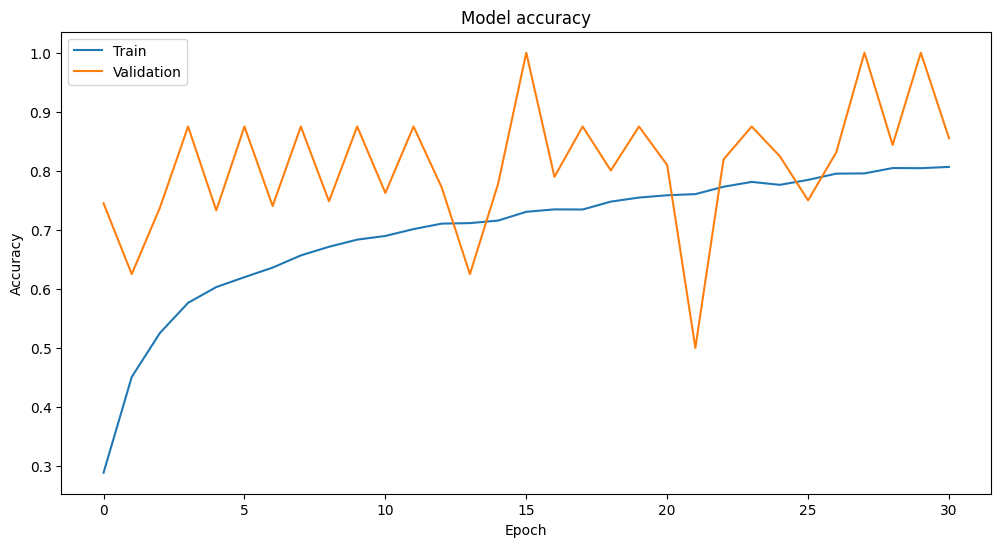

In [26]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
# Generate predictions for a batch of test images and compare with true labels
image_batch, label_batch = next(test_generator)  # Retrieve a batch of images and their true labels from the test generator
predictions = model.predict_on_batch(image_batch)  # Use the model to predict classes for the image batch
predicted_class_indices = np.argmax(predictions, axis=-1)  # Determine the predicted class indices based on highest prediction scores
true_class_indices = np.argmax(label_batch, axis=-1)  # Extract the true class indices from the label batch for comparison

In [29]:
# Adjust image batch to proper format for visualization
image_batch_display = image_batch * 255  # Rescale images back to 0-255 range from normalized 0-1 range
image_batch_display = image_batch_display.astype('uint8')  # Convert image data type to unsigned integer for display compatibility

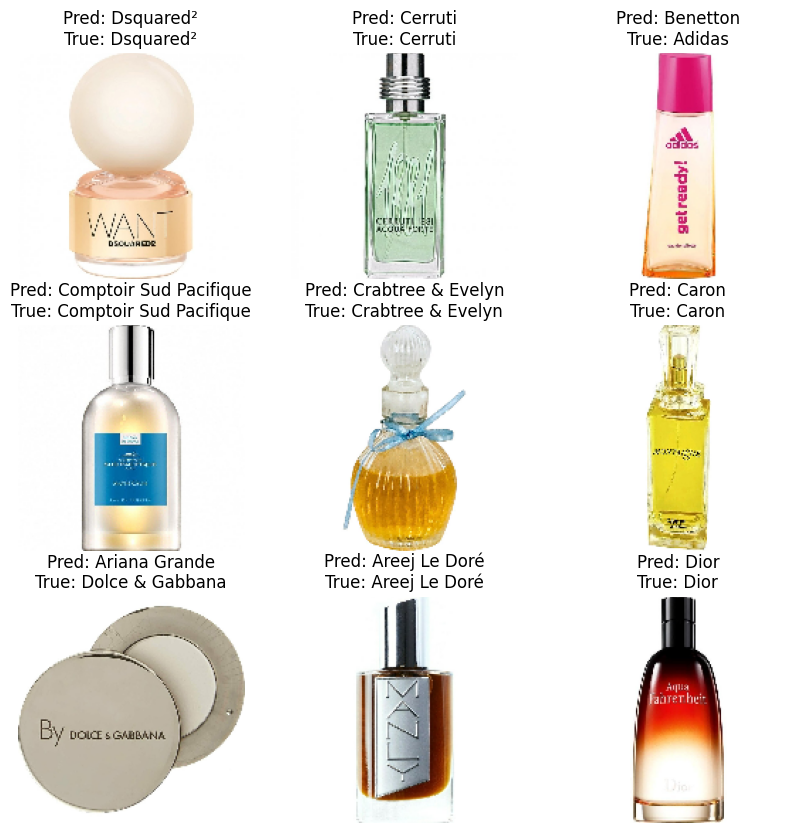

In [30]:
plt.figure(figsize=(10, 10))  # Set up figure size for displaying images
for i in range(9):  # Loop through the first 9 images in the batch
    ax = plt.subplot(3, 3, i + 1)  # Arrange images in a 3x3 grid
    plt.imshow(image_batch_display[i])  # Display the i-th image from the batch
    predicted_label = list(train_generator.class_indices.keys())[predicted_class_indices[i]]  # Retrieve the predicted label using the index
    true_label = list(train_generator.class_indices.keys())[true_class_indices[i]]  # Retrieve the true label using the index
    plt.title(f'Pred: {predicted_label}\nTrue: {true_label}')  # Display predicted and true labels above the image
    plt.axis('off')  # Hide the axis for a cleaner look
plt.show()  # Display the figure with the images and labels

## Interpretation

In initial training show the model reaching a validation accuracy of around 75% before fine-tuning. After fine-tuning, the accuracy on the validation set increases significantly, reaching a peak of 100% at epoch 177 and stabilizing at over 85%. This suggests that fine-tuning has had a positive effect, allowing the model to learn more detailed features. However, 100% accuracy on validation at epoch 177 could also be a sign of overfitting.

The accuracy graph shows the model's accuracy on the training and validation datasets over a number of epochs. The training accuracy (blue line) increases steadily, which is typical as the model learns from the data. The validation accuracy (orange line) has more variance, with some peaks and troughs. It generally improves but has some drops, which could indicate the model is starting to overfit or that the validation data has some variability the model is sensitive to. Ideally, both lines should converge and stabilize, which indicates that the model has learned well and generalizes to new data.

# AI Statement

I used ChatGPT for help with debugging, adding comments to code and editing the narrative for clarity and flow.

# Bibliography

TensorFlow. (2024). Transfer learning and fine-tuning. TensorFlow. https://www.tensorflow.org/tutorials/images/transfer_learning